In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import matplotlib.pyplot as plt
fs = 12
plt.rc('font', family='serif')
plt.rc('font', size=fs)
plt.rc('facecolor', )
import pandas as pd
import scipy.io as sio

# met mast functions and utilities
sys.path.append('../')
import met_funcs as MET
import vis as vis
import utils as utils
import pickle as pkl

Perhaps a better way:
    
    - Parse date
    - List files present
    - Load data
    - apply 3s low-pass filter
        
   -  Calculate dynamic parameters
        sigma 1
        Lambda 1 - only for multipoint calcs
        
    - resample to T sec?
        Not all events are detected in the same window
        some want T = 10 s 
        some want T = 12 s         
        some want T = 6 s

    - Calculcate/load threshold values
        
        EWM
            V_e1
            V_e50
            
        EOG
            V_egust
            
        ETM
            sigma_e
            
        EDC
            theta_e
            
        ECD
            theta_cg
            
        EWS
            alpha_e
           
    - Compare to velocity/direction signals
    
    - Write out variables
    - make dataframe containing at least:
        
            WSmax
            WSmin
            WSmean
            WDmax
            WDmin
            WDmean
            Datetime
            threshold(s)
            test value(s)
        

### Static parameters

In [2]:
###########################################
def setup_IEC_params(probeheight=100):
    """
    Establish IEC parameters.

    This function takes inputs from a pandas DataFrame containing all of the desired data at the given probe height and establishes all of the International Electrotechnical Commission (IEC) parameters for the given input data and probe height.

        :param sonicdat: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param probeheight: An integer or float value used to define the desired height of the probe from which to begin data analysis (m).

        :returns params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.
    """

    ### quantities of interest for IEC
    # turbulence estimate over period, standard deviation of cupspeed
    # filter wind directions that cross the 360/0 threshold
#     if sonicdat['WD'].mean() > 180:
#         sonicdat.loc[sonicdat['WD'] < 100, 'WD'] += 360
#     else:
#         sonicdat.loc[sonicdat['WD'] > 350, 'WD'] += -360

    params = {'turbclass': 'IA'}

    # dummy vertical coordinate
    params['z'] = np.linspace(0, 135, 136)
    # dummy velocity span
    params['z'] = np.linspace(0, 40, 120)
    
    ######## parameters
    ### IEC parameters
    
    # Based on IEC Class IA
    params['Vref'] = 50.0  #m/s
    params['Iref'] = 0.16  # turbulence intensity
    # 'average' velocity
    params['Vave'] = 0.2 * params['Vref']
    # shear exponent
    params['alpha'] = 0.2
    # longitudinal turbulence scale parameter
    if probeheight < 60:
        params['Lambda_1'] = 0.7 * probeheight  # m
    else:
        params['Lambda_1'] = 42  # m
        
    # shear exponent
    params['alpha'] = 0.2
    params['beta'] = 6.4

    ### data parameters
    # NREL GE1.5MW rotor diameter
    params['D'] = 80
    # sampling frequency
    params['freq'] = 20  # Hz
    # probe height
    params['probeheight'] = probeheight
    ### normal wind profile model
    params['zhub'] = 80  # m
    # 'hub' height velocity (really just mean probe velocity)
#     params['vhub'] = sonicdat['WS'].mean()  # m/s
    # dummy vertical coordinate
#     params['z'] = np.linspace(0, 120, 120)
#     # standard normal velocity profile
#     params['vprofile'] = params['vhub'] * (
#         params['z'] / params['zhub'])**params['alpha']
#     params['sigma_data'] = sonicdat['WS'].std()

    ### Normal Wind speed distributions
    # dummy velocity data
    params['vrange'] = np.linspace(0, params['Vref'], 100)
    # velocity probability density function
    params['pdf'] = params['vrange']/(params['Vave']**2)* \
        np.exp(-np.pi*params['vrange']**2/(np.sqrt(2)*params['Vave']**2))
    # velocity cumulative probability density function
    params['cdf'] = 1.0 - np.exp(
        -np.pi * (params['vrange'] / (2 * params['Vave']))**2)

    # Extreme wind speed model (EWM)
    params['Ve50'] = 1.4 * params['Vref'] * (
        params['probeheight'] / params['zhub'])**(0.11)
    params['Ve01'] = 0.8 * params['Ve50']

    return params


###########################################

In [3]:
params = setup_IEC_params()

In [4]:
alpha_pos = np.load(
    '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/pos_alpha_limit.npy'
)
alpha_neg = np.load(
    '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/neg_alpha_limit.npy'
)
alpha_reference_velocity = np.load(
    '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/alpha_reference_velocity.npy'
)

In [5]:
%%time
datapath = '/Volumes/135mData/M5Twr/20Hz/mat/2015/02/01'
files = os.listdir(datapath)


# make empty dataframe
sonicdat = pd.DataFrame()
sonicdat_lo = pd.DataFrame()
sonicdat_hi = pd.DataFrame()

# Load each file and concatenate
for file in files:
    data = sio.loadmat(os.path.join(datapath, file)) 

    # make a vector of datetimes for the data
    timerange = utils.matlab_datenum_to_python_datetime(
        data['time_UTC'][0][0][0].flatten())
    tmp = MET.make_dataframe_for_height(data, timerange, probeheight=100)
    sonicdat = pd.concat((sonicdat, tmp))
    
    tmp = MET.make_dataframe_for_height(data, timerange, probeheight=38)
    sonicdat_lo = pd.concat((sonicdat_lo, tmp))
    
    tmp = MET.make_dataframe_for_height(data, timerange, probeheight=122)
    sonicdat_hi = pd.concat((sonicdat_hi, tmp))
    
# 3 second rolling average
sonicdat = sonicdat.rolling(60, center=True, min_periods=1).mean()
sonicdat.index = pd.DatetimeIndex(sonicdat.index)

sonicdat_lo = sonicdat_lo['WS'].rolling(60, center=True, min_periods=1).mean()
sonicdat_hi = sonicdat_hi['WS'].rolling(60, center=True, min_periods=1).mean()

CPU times: user 39.4 s, sys: 3.78 s, total: 43.1 s
Wall time: 50.4 s


### test EOG events

In [6]:
def sonic_data_resampler(sonicdat, T):
    
    mins =  sonicdat.resample('{}S'.format(T)).min()
    mins.columns = ['{}_min'.format(x) for x in mins.columns]

    maxs =  sonicdat.resample('{}S'.format(T)).max()
    maxs.columns = ['{}_max'.format(x) for x in maxs.columns]

    means =  sonicdat.resample('{}S'.format(T)).mean()
    means.columns = ['{}_mean'.format(x) for x in means.columns]

    sonic_resample = pd.concat([mins, maxs, means], axis=1)
    
    return sonic_resample

In [6]:
def find_EOG_events(sonicdat, params, T=10.5):
    
    # resample at T seconds
    sonic_10_5s = sonic_data_resampler(sonicdat, T)

    # calc IEC standard velocity variance
    sigma_1 = params['Iref'] * (0.75 * sonic_10_5s['WS_mean'] + 5.6)

    test1 = 1.35*(params['Ve01']-sonic_10_5s['WS_mean'])
    test2 = 3.3*(sigma_1/(1+0.1*params['D']/params['Lambda_1']))
    
    # IEC gust velocity magnitude threshold
    Vgust = np.min(np.vstack([test1.values, test2.values]), axis=0)

    
    t = np.linspace(0, T, 101)
    WS_pos_gustlim = np.zeros(Vgust.shape)
    WS_neg_gustlim = np.zeros(Vgust.shape)
    for ii, vv in enumerate(Vgust):
        mod = 0.37 * vv * np.sin(3 * np.pi * t / T) * (1 - np.cos(2 * np.pi * t / T))
        WS_pos_gustlim[ii] = sonic_10_5s['WS_mean'].iloc[ii] - mod.min()
        WS_neg_gustlim[ii] = sonic_10_5s['WS_mean'].iloc[ii] - mod.max()

    sonic_10_5s['WS_pos_gustlim'] = WS_pos_gustlim
    sonic_10_5s['WS_neg_gustlim'] = WS_neg_gustlim

    posmask = sonic_10_5s['WS_max'] > sonic_10_5s['WS_pos_gustlim']
    negmask = sonic_10_5s['WS_min'] < sonic_10_5s['WS_neg_gustlim']
    
    # test for EOG events (pos or pos+neg)
    singletest = sonic_10_5s[posmask]
    doubletest = sonic_10_5s[posmask & negmask]
    
    return singletest, doubletest

In [7]:
###########################################
def find_ETM_events(sonicdat, params):
    """
    Find extreme turbulence model events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme turbulence model events, and returns the findings in an object which can be used to index files later.

        :param sonicdat: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :returns ETMeventfound: An object used to store any significant extreme turbulence model events.
    """

    # Extreme turbulence model
    tmp = sonic_data_resampler(sonicdat, 600)

    c = 2  # m/s
    tmp['sigmatest'] = c * params['Iref'] * (0.072 * (params['Vave'] / c + 3) *
                                    (sonicdat['WS'].resample('10T').mean() / c + 4) + 10)
    tmp['sigma_1'] = sonicdat['WS'].resample('10T').std()

    ETM_events_found = tmp[tmp['sigma_1'] > tmp['sigmatest']]

    return ETM_events_found


In [72]:
###########################################
def find_EDC_events_v2(sonicdat, params, T=6):
    """
    Find extreme wind direction change events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme wind direction change events, and returns the findings in an object which can be used to index files later.

        :param sonicdat: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :param T: A float used to define the period for search (Seconds).

        :returns EDCeventfound: An object used to store any significant extreme wind direction change events.
    """

    # Resample data at 6 second period
    sonic_6s = sonic_data_resampler(sonicdat, 6)
    
    # turbulence standard dev from IEC def.
    sonic_6s['sigma_1'] = params['Iref'] * (0.75 * sonic_6s['WS_mean'] + 5.6)

    # Maximum allowable change in wind direction over a 6 second period
    sonic_6s['delta_WD_thresh'] = np.degrees(4 * np.arctan( sonic_6s['sigma_1'] / (sonic_6s['WS_mean'] * (1 + 0.1 * params['D'] / params['Lambda_1']))))
#     sonic_6s['neg_delta_WD_thresh'] = -sonic_6s['pos_delta_WD_thresh']
    
    # recorded wind direction change in 6 second period
    
    sonic_6s['delta_WD'] = sonic_6s['WD_mean'].diff(periods=2)

    sonic_6s['delta_WD'][sonic_6s['delta_WD'] > 180] = 180 - sonic_6s['delta_WD'][sonic_6s['delta_WD'] > 180] 

    EDC_events_found = sonic_6s[(sonic_6s['delta_WD'] > sonic_6s['delta_WD_thresh'] )]

    return EDC_events_found


###########################################

In [31]:
###########################################
def find_EDC_events(sonicdat, params, T=6):
    """
    Find extreme wind direction change events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme wind direction change events, and returns the findings in an object which can be used to index files later.

        :param sonicdat: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :param T: A float used to define the period for search (Seconds).

        :returns EDCeventfound: An object used to store any significant extreme wind direction change events.
    """

    # Resample data at 6 second period
    sonic_6s = sonic_data_resampler(sonicdat, 6)
    
    # turbulence standard dev from IEC def.
    sonic_6s['sigma_1'] = params['Iref'] * (0.75 * sonic_6s['WS_mean'] + 5.6)

    # Maximum allowable change in wind direction over a 6 second period
    sonic_6s['pos_delta_WD_thresh'] = np.degrees(4 * np.arctan( sonic_6s['sigma_1'] / (sonic_6s['WS_mean'] * (1 + 0.1 * params['D'] / params['Lambda_1']))))
    sonic_6s['neg_delta_WD_thresh'] = -sonic_6s['pos_delta_WD_thresh']
    
    # recorded wind direction change in 6 second period
#     sonic_6s['delta_WD'] = np.abs(sonic_6s['WD_max']- sonic_6s['WD_min'])
    sonic_6s['delta_WD'] = np.abs(sonic_6s['WD_max']- sonic_6s['WD_min'])

    sonic_6s['delta_WD'][sonic_6s['delta_WD'] > 180] = 360 - sonic_6s['delta_WD'][sonic_6s['delta_WD'] > 180]
#     sonic_6s['delta_WD'][sonic_6s['delta_WD'] < -180] += 360

    EDC_events_found = sonic_6s[(sonic_6s['delta_WD'] > sonic_6s['pos_delta_WD_thresh'] ) | (sonic_6s['delta_WD'] < sonic_6s['neg_delta_WD_thresh'] )]

    return EDC_events_found


###########################################

In [92]:
alpha = np.log(sonicdat_hi/sonicdat_lo) / np.log(122/38)
alpha.index = pd.DatetimeIndex(alpha.index)

tmp = pd.concat([alpha.resample('12S').min(), 
                 alpha.resample('12S').max(),
                 alpha.resample('12S').mean()], axis=1)
tmp.columns = ['alpha_min', 'aMlpha_max', 'alpha_mean']

sonic_12s = sonic_data_resampler(sonicdat, 12)

shearevents = pd.concat([sonic_12s, tmp], axis=1)

NameError: name 'sonicdat_hi' is not defined

In [93]:
###########################################
def find_EWS_events(sonicdat,
                    sonicdat_lo,
                    sonicdat_hi,
                    params,
                    alpha_neg,
                    alpha_pos,
                    alpha_reference_velocity,
                    T=12):
    """
    Find extreme coherent wind shear events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme coherent wind shear events, and returns the findings in an object which can be used to index files later.

        :param sonicdat_lo: A pandas DataFrame containing data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param sonicdat_hi: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :param T: A float used to define the period for search (Seconds).

        :returns EWSeventfound: An object used to store any significant extreme wind shear events.
    """

    alpha = np.log(sonicdat_hi/sonicdat_lo) / np.log(122/38)
    alpha.index = pd.DatetimeIndex(alpha.index)

    tmp = pd.concat([alpha.resample('12S').min(), 
                 alpha.resample('12S').max(),
                 alpha.resample('12S').mean()], axis=1)
    tmp.columns = ['alpha_min', 'alpha_max', 'alpha_mean']

    # resample sonic data at 12 s
    sonic_12s = sonic_data_resampler(sonicdat, 12)
    
    # add shear calc to dataframe
    shearevents = pd.concat([sonic_12s, tmp], axis=1)
    
    # add limits of shear exponent based on vhub
    shearevents['alpha_pos_limit'] = np.interp(shearevents['WS_mean'], alpha_reference_velocity, alpha_pos)
    shearevents['alpha_neg_limit'] = np.interp(shearevents['WS_mean'], alpha_reference_velocity, alpha_neg)

    # create mask to identify valid extreme events
    vhub_mask = shearevents['WS_mean'] > alpha_reference_velocity.min()
    aneg_mask = shearevents['alpha_min'] < shearevents['alpha_neg_limit']
    apos_mask = shearevents['alpha_max'] > shearevents['alpha_pos_limit']

    # identify extreme shear events (EWS)
    EWS_event_found = shearevents[vhub_mask & (aneg_mask | apos_mask)]
    
    return EWS_event_found

In [121]:
def find_ECD_events(sonicdat, params, T=10):
    """
    Find extreme coherent wind gust with wind direction change events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme coherent wind gust with wind direction change events, and returns the findings in an object which can be used to index files later.

        :param sonicdat: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :param T: A float used to define the period for search (Seconds).

        :returns ECDeventfound: An object used to store any significant extreme coherent wind gust with wind direction change events.
    """

    # Extreme coherent gust with direction change (ECD)

    Vcg = 15  # m/s See IEC standards

    # resample sonic data at 12 s
    sonic_10s = sonic_data_resampler(sonicdat, 10)

    theta_cg = pd.Series(index=sonic_10s.index, data=180*np.ones(len(sonic_10s.index)))
    theta_cg[sonic_10s['WS_mean'] > 4.0] = 720.0 / sonic_10s['WS_mean'][sonic_10s['WS_mean'] > 4.0]

    sonic_10s['delta_WD'] = sonic_10s['WD_mean'].diff(periods=2)
    sonic_10s['delta_WS'] = sonic_10s['WS_mean'].diff(periods=2)

    ECDeventfound = sonic_10s[(sonic_10s['delta_WD'] > theta_cg) & (sonic_10s['delta_WS'] > 0.5*Vcg)]


    return ECDeventfound

In [94]:
EWS_event_found = find_EWS_events(sonicdat,
                    sonicdat_lo,
                    sonicdat_hi,
                    params,
                    alpha_neg,
                    alpha_pos,
                    alpha_reference_velocity,
                    T=12)

NameError: name 'sonicdat_lo' is not defined

### Thresholds

In [95]:
def EWS_fig(allshearcalcs, EWSevents, alpha_reference_velocity, alpha_pos, alpha_neg, lim=6.5):
    fig, ax = plt.subplots(figsize=(5,3))

    allshearcalcs[(allshearcalcs['Vhub'] > lim) & ~((allshearcalcs['alpha_mean'] > allshearcalcs['alpha_pos_limit']) | (allshearcalcs['alpha_mean'] < allshearcalcs['alpha_neg_limit']))].plot.scatter('Vhub', 'alpha_mean', ax=ax, color='w', edgecolor='C0')
    apos = EWSevents[EWSevents['alpha_max'] > EWSevents['alpha_pos_limit']].plot.scatter('Vhub', 'alpha_max', ax=ax, color='C2', edgecolor='C2', label=r'$\alpha_+$')
    aneg = EWSevents[EWSevents['alpha_min'] < EWSevents['alpha_neg_limit']].plot.scatter('Vhub', 'alpha_min', ax=ax, color='C1', edgecolor='C1', label=r'$\alpha_-$')

    ax.plot(alpha_reference_velocity, alpha_pos, color='C0')
    ax.plot(alpha_reference_velocity, alpha_neg, color='C0')

    ax.legend(frameon=False)#loc=6, bbox_to_anchor = (1,0.5))

    ax.set_ylabel('Shear Exponent [-]')
    ax.set_xlabel('Hub-Height Velocity [m/s]')

    fig.tight_layout()
    
    return fig, ax


In [7]:
# time range
# years  = [ int(a) for a in np.arange(2012,2019,1) ] #
# months = [ int(a) for a in np.arange(1,12.1,1) ]
# days = [int(a) for a in np.arange(1,31.1,1)]

years  = [ 2015 ] #
months = [ 11 ]
days = [int(a) for a in np.arange(1,31.1,1)]

# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/)
towerID = 'M5'
metDataPath = '/Volumes/135mData/{}Twr/20Hz/mat/'.format(towerID)

savepath = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_3'
try:
    os.makedirs(savepath)
except:
    pass

In [97]:
alpha_pos = np.load('../../data/pos_alpha_limit.npy')
alpha_neg = np.load('../../data/neg_alpha_limit.npy')
alpha_reference_velocity = np.load('../../data/alpha_reference_velocity.npy')

In [122]:
for year in years:
    for month in months:

        # begin empty lists for events
        EDCevents = pd.DataFrame()
        ECDevents = pd.DataFrame()
#         allshearcalcs = pd.DataFrame()
        
        print('reading 20Hz data for {}/{}'.format(year, month))

        for day in days:
            datapath = os.path.join(metDataPath, str(year),
                                    str(month).zfill(2),
                                    str(day).zfill(2))

            # establish existence of directory
            try:
                fPaths = os.listdir(datapath)
            except:
                print('empty datapath: {}'.format(datapath))
                continue

            if len(fPaths) is 0:
                continue

            for filenum, file in enumerate(fPaths):

                # load data
                try:
                    data = sio.loadmat(os.path.join(datapath, file))  #, variable_names=varnames)
                except:
                    print('data not found? looks like you have some homework...')
                    continue
                
                ndat = 10 * 60 * 20  # minutes*seconds/minute*samples/second
                if len(data['Sonic_CupEqHorizSpeed_100m'][0][0][0].flatten()) < 10000:
                    print('data size mismatch, {}'.format(file))
                    print('only {} out of 12000 points available'.format(len(data['Sonic_CupEqHorizSpeed_100m'][0][0][0].flatten())))
                    continue
    
                # print('data loaded from {}'.format(os.path.join(datapath, file)))

                # make a vector of datetimes for the data
                timerange = utils.matlab_datenum_to_python_datetime(
                    data['time_UTC'][0][0][0].flatten())

                probeheight = 87 # m
                # make a dataframe for the instrument at probeheight
                sonicdat = MET.make_dataframe_for_height(
                    data, timerange, probeheight=probeheight)
                
                
                sonicdat.index = pd.DatetimeIndex(sonicdat.index)
#                 sonicdat_lo = MET.make_dataframe_for_height(
#                     data, timerange, probeheight=38)
#                 sonicdat_hi = MET.make_dataframe_for_height(
#                     data, timerange, probeheight=122)
                temp = sonicdat['WS'].dropna()
                if len(temp) < 1000:
                    continue
                
                # extract variables needed for classificiation of IEC events
                params = MET.setup_IEC_params() # sonicdat, probeheight=100

                EDC_events_found = find_EDC_events(sonicdat, params)
                EDCevents = pd.concat([EDCevents, EDC_events_found])
                
                ECD_events_found = find_ECD_events(sonicdat, params)
                ECDevents = pd.concat([ECDevents, ECD_events_found])
                
#                 allshearcalcs = pd.concat([allshearcalcs, shearevents])
                                
#         if len(EWSevents) > 0:
#             filename = 'EWSevents_{}_{}.pkl'.format(year, month)
#             savefile = os.path.join(savepath, filename)
#             print('EWS event detected. Stored to: {}'.format(filename))
#             with open(savefile, 'wb') as f:
#                 pkl.dump(EWSevents, f, pkl.HIGHEST_PROTOCOL)

reading 20Hz data for 2015/11
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/01
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/02
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/03
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/04
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/05
data size mismatch, 11_06_2015_16_50_00_000.mat
only 9311 out of 12000 points available


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/31


In [130]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [40]:
days = [8]

In [ ]:
for year in years:
    for month in months:

        # begin empty lists for events
        sonicdat = pd.DataFrame()
        
        print('reading 20Hz data for {}/{}'.format(year, month))

        for day in days:
            datapath = os.path.join(metDataPath, str(year),
                                    str(month).zfill(2),
                                    str(day).zfill(2))

            # establish existence of directory
            try:
                fPaths = os.listdir(datapath)
            except:
                print('invalid datapath: {}'.format(datapath))
                continue

            for filenum, file in enumerate(fPaths):

                # load data
                try:
                    data = sio.loadmat(os.path.join(datapath, file))  #, variable_names=varnames)
                except:
                    print('data not found? looks like you have some homework...')
                    continue
                
#                 ndat = 10 * 60 * 20  # minutes*seconds/minute*samples/second
#                 if len(data['Sonic_CupEqHorizSpeed_100m'][0][0][0].flatten()) < 10000:
#                     print('data size mismatch, {}'.format(file))
#                     print('only {} out of 12000 points available'.format(len(data['Sonic_CupEqHorizSpeed_100m'][0][0][0].flatten())))
#                     continue
    
                # print('data loaded from {}'.format(os.path.join(datapath, file)))

                # make a vector of datetimes for the data
                timerange = utils.matlab_datenum_to_python_datetime(
                    data['time_UTC'][0][0][0].flatten())

                probeheight = 87 # m
                # make a dataframe for the instrument at probeheight
            tmp = MET.make_dataframe_for_height(data, timerange, probeheight=probeheight)
            sonicdat = pd.concat([sonicdat, tmp], axis=0)
    
        
    print('month of {}/{} loaded'.format(year, month))
    print(sonicdat.shape)

reading 20Hz data for 2015/11
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/01
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/02
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/03
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/04
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/05
data size mismatch, 11_06_2015_16_50_00_000.mat
only 9311 out of 12000 points available


KeyboardInterrupt: 

In [9]:
years

[2015]

In [10]:
# import os
datapath = os.path.join(metDataPath, str(years[0]),
                                    str(months[0]).zfill(2),
                                    str(8).zfill(2))

all_files = os.listdir(datapath)
all_files = [os.path.join(datapath, x) for x in all_files]



In [41]:
import time


In [103]:
sonicdat = MET.make_dataframe_for_height(data, 119)

TypeError: 'int' object is not subscriptable

In [104]:
starttime = time.time()
probeheight = 87 # m
sonicdat = pd.DataFrame()
for f in all_files[0:1]:
    data = sio.loadmat(f)
    timerange = utils.matlab_datenum_to_python_datetime(data['time_UTC'][0][0][0].flatten())

    # make a dataframe for the instrument at probeheight
    tmp = MET.make_dataframe_for_height(data, timerange, probeheight=probeheight)
    sonicdat = pd.concat([sonicdat, tmp], axis=0)

sonicdat.index = pd.DatetimeIndex(sonicdat.index)

tmp = find_EDC_events(sonicdat, params)
print(time.time() - starttime)

0.539215087890625


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [106]:
[x for x in data.keys() if 'direction' in x]

['Sonic_direction_119m',
 'Sonic_direction_100m',
 'Sonic_direction_74m',
 'Sonic_direction_61m',
 'Sonic_direction_41m',
 'Sonic_direction_15m']

In [111]:
sonicdat = MET.make_dataframe_for_height(data, timerange, probeheight=119)
sonicdat = sonicdat.rolling(60, min_periods=1).mean()

In [112]:
cupvane = MET.make_dataframe_for_height(data, timerange, probeheight=122)
cupvane = cupvane.rolling(60, min_periods=1).mean()

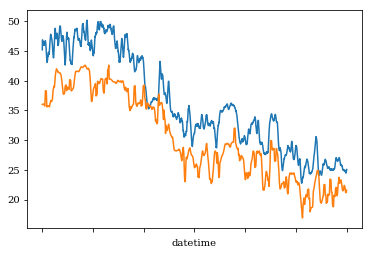

In [113]:
fig, ax = plt.subplots()
sonicdat['WD'].plot(ax=ax)
cupvane['WD'].plot(ax=ax)

In [37]:
%%time
probeheight = 87 # m
events = pd.DataFrame()

for f in all_files:
    data = sio.loadmat(f)
    timerange = utils.matlab_datenum_to_python_datetime(data['time_UTC'][0][0][0].flatten())

    # make a dataframe for the instrument at probeheight
    sonicdat = MET.make_dataframe_for_height(data, timerange, probeheight=probeheight)
    sonicdat.index = pd.DatetimeIndex(sonicdat.index)

    
    tmp = find_EDC_events(sonicdat, params)
    events = pd.concat([events, tmp], axis=0)


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 23.8 s, sys: 1.58 s, total: 25.4 s
Wall time: 34.1 s


In [38]:
events

,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,sigma_1,pos_delta_WD_thresh,neg_delta_WD_thresh,delta_WD
datetime,,,,,,,,,,
2015-11-08 16:47:24,1.037323,106.895090,1.372807,256.640881,1.165819,143.628015,1.035898,146.949036,-146.949036,149.745792
2015-11-08 17:08:36,2.218538,111.382265,2.402939,273.430436,2.329428,146.302688,1.175531,91.888504,-91.888504,162.048171
2015-11-08 18:07:06,0.746386,106.011426,1.705510,254.988321,1.142175,186.788724,1.033061,148.903529,-148.903529,148.976895
2015-11-08 19:18:36,1.982516,72.042026,3.067650,161.825296,2.544647,111.406825,1.201358,86.527928,-86.527928,89.783270
2015-11-08 20:02:36,2.788684,109.373939,2.902352,239.162764,2.843354,140.813552,1.237203,80.309726,-80.309726,129.788825
2015-11-08 20:40:54,1.737102,25.150516,2.252770,137.461541,2.086954,109.780340,1.146435,99.082030,-99.082030,112.311024
2015-11-08 22:06:36,1.964619,106.401615,2.406809,306.355420,2.167983,143.754029,1.156158,96.522157,-96.522157,160.046195
2015-11-08 22:06:42,2.406809,109.098511,2.849601,298.402468,2.567744,144.465003,1.204129,86.000574,-86.000574,170.696042


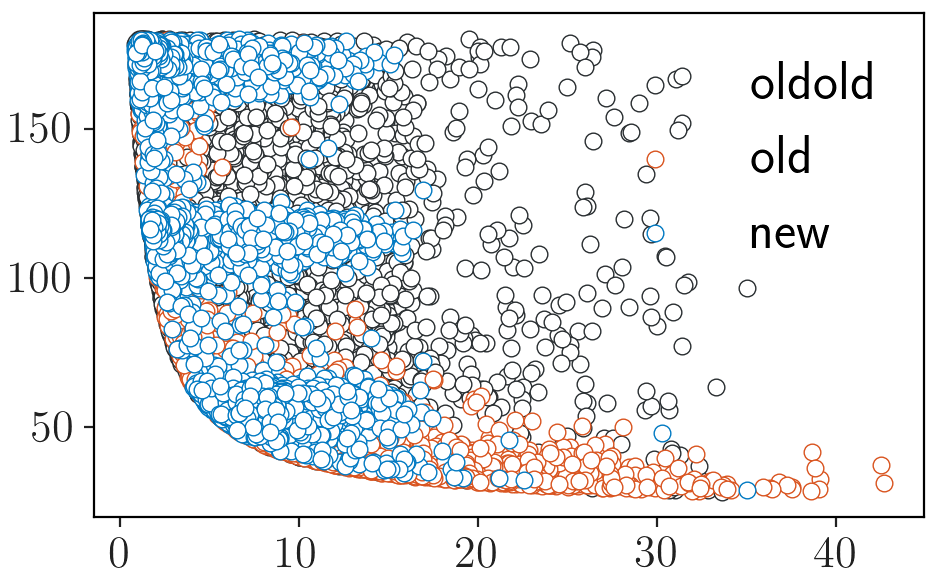

In [108]:
fig, ax = plt.subplots()

# EDCevents.plot.scatter('WS_mean', 'delta_WD', ax=ax, edgecolor='C1', facecolor='w', label='old')
# EDCevents_v2.plot.scatter('WS_mean', 'delta_WD', ax=ax, edgecolor='C2', facecolor='w', label='new')

ax.scatter(tmp['WS_mean'], tmp['delta_WD'], edgecolor='C0', facecolor='w', label='oldold')
ax.scatter(EDCevents['WS_mean'], EDCevents['delta_WD'], edgecolor='C2', facecolor='w', label='old')
ax.scatter(EDCevents_v2['WS_mean'], EDCevents_v2['delta_WD'], edgecolor='C1', facecolor='w', label='new')

ax.legend()

In [ ]:
###########################################
def find_EWS_events(sonicdat,
                    sonicdat_lo,
                    sonicdat_hi,
                    params,
                    alpha_neg,
                    alpha_pos,
                    alpha_reference_velocity,
                    T=12):
    """
    Find extreme coherent wind shear events.

    This function takes inputs from a pandas DataFrame containing all of the desired data and International Electrotechnical Commission (IEC) parameters at the given period for search, determines extreme coherent wind shear events, and returns the findings in an object which can be used to index files later.

        :param sonicdat_lo: A pandas DataFrame containing data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param sonicdat_hi: A pandas DataFrame containing all of the desired data at the given probe height including wind speed, wind direction, and the date and timestamps of the input data.

        :param params: A dictionary containing all of the parameters established by the IEC for the given input data and probe height.

        :param T: A float used to define the period for search (Seconds).

        :returns EWSeventfound: An object used to store any significant extreme wind shear events.
    """

    alpha = np.log(sonicdat_hi/sonicdat_lo) / np.log(122/38)
    alpha.index = pd.DatetimeIndex(alpha.index)

    tmp = pd.concat([alpha.resample('12S').min(), 
                 alpha.resample('12S').max(),
                 alpha.resample('12S').mean()], axis=1)
    tmp.columns = ['alpha_min', 'alpha_max', 'alpha_mean']

    # resample sonic data at 12 s
    sonic_12s = sonic_data_resampler(sonicdat, 12)
    
    # add shear calc to dataframe
    shearevents = pd.concat([sonic_12s, tmp], axis=1)
    
    # add limits of shear exponent based on vhub
    shearevents['alpha_pos_limit'] = np.interp(shearevents['WS_mean'], alpha_reference_velocity, alpha_pos)
    shearevents['alpha_neg_limit'] = np.interp(shearevents['WS_mean'], alpha_reference_velocity, alpha_neg)

    # create mask to identify valid extreme events
    vhub_mask = shearevents['WS_mean'] > alpha_reference_velocity.min()
    aneg_mask = shearevents['alpha_min'] < shearevents['alpha_neg_limit']
    apos_mask = shearevents['alpha_max'] > shearevents['alpha_pos_limit']

    # identify extreme shear events (EWS)
    EWS_event_found = shearevents[vhub_mask & (aneg_mask | apos_mask)]
    
    return EWS_event_found

In [118]:
Vcg = 15  # m/s See IEC standards

# resample sonic data at 12 s
sonic_10s = sonic_data_resampler(sonicdat, 10)

theta_cg = pd.Series(index=sonic_10s.index, data=180*np.ones(len(sonic_10s.index)))
theta_cg[sonic_10s['WS_mean'] > 4.0] = 720.0 / sonic_10s['WS_mean'][sonic_10s['WS_mean'] > 4.0]

sonic_10s['delta_WD'] = sonic_10s['WD_mean'].diff(periods=2)
sonic_10s['delta_WS'] = sonic_10s['WS_mean'].diff(periods=2)

ECDevents = sonic_10s[(sonic_10s['delta_WD'] > theta_cg) & (sonic_10s['delta_WS'] > 0.5*Vcg)]


In [22]:
file = '01_10_2017_23_00_00_000.mat'
year =2017
month = 1

if (str(month).zfill(2) in file):
    print('and')

SyntaxError: invalid syntax (<ipython-input-22-e1c55718307a>, line 5)